# Variational Autoregressive Network on Ising Model

Here, we attempt to sample and output log-probabilities approximately using a variational autoregressive network that trains to minimize free energy

If opening directly on Colab (or downloaded this notebook alone locally), run the following cell to download the dependencies of this noteook:

In [ ]:
!curl -o ising.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/ising.py
!curl -o train.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/train.py
!curl -o library.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/library.py

Here, we import tensorflow (2.x) and other dependent modules:

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import library #User defined module to define the models

## Naive PixelCNN architecture

We're going to use the PixelCNN architecture which uses a masked convolutional neural network to return some probabilities, given an input lattice of Ising spins. Let's initialize the network with depth 2, which has one Masked Convolution layer with a LeakyRelu activation and a 1-kernel regular convolutional layer: 

In [2]:
model = library.PixelCNN(L=24, net_depth=3, net_width=16, kernel_size=3)#See library.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model
trainer = train.Trainer(model, batch_size=50)

Let's check out the model design here:

In [3]:
trainer.model.net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d (MaskedConv2D) (None, 24, 24, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        272       
_________________________________________________________________
res_block (ResBlock)         (None, 24, 24, 16)        2592      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 1)         17        
Total params: 3,041
Trainable params: 3,041
Non-trainable params: 0
_________________________________________________________________


This is an unsupervised learning model since the network generates its own training data. In particular, we're attempting reinforcement learning to optimize the (expectation value of) free energy of the generated lattices. Let's train the model we defined here.

In [ ]:
beta = 0.5
history = trainer.train_loop(iter=100, beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

The output object "history" is a python dictionary which records the values of various metrics like free energy, energy and time taken per training step. This helps us visualize how the training performance so that we can tweak various parameters to improve it. Here, we plot mean energy against the training step:

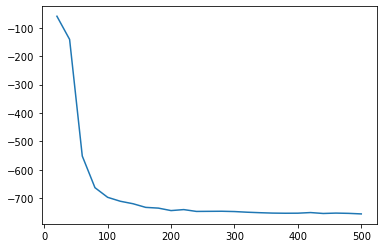

In [5]:
x = history['step']
y = history['Energy mean']
plt.plot(x, y)

Let's calculate and plot the exact theoretical free energy of the infinite square ferromagnetic Ising model($K=\beta$). We'll use the SciPy method "quad" to find this integral:
$$ -\beta F = \frac{log(2)}{2} + \frac{1}{2 \pi} \int_0^\pi log\left[ cosh^2(2K) + \frac{1}{k}\sqrt{1 + k^2 - 2k.cos(2\theta)} \right] d\theta$$
where $$ k = \frac{1}{sinh^2(2K)}$$

In [2]:
from scipy import integrate
import math

In [3]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

We use this function to evaluate the integral over a vector of values for beta:

In [4]:
def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

beta = np.arange(0.25, 0.65, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

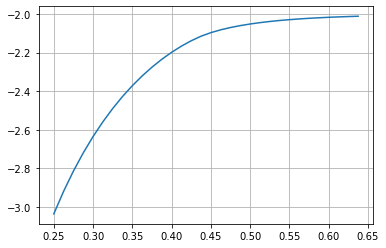

In [7]:
plt.plot(beta, F)
plt.grid()
plt.show()

Here, we have the plot free energy against temperature evaluated from the exact theoretical solution

Instead of training for many values of beta from the scratch, we'll directly download a folder containing the trained neural network weights:

In [ ]:
#Uncomment below line and run in case of using Colab
#!svn export 'https://github.com/dinesh110598/ising-autoregressive/trunk/PCNN_Weights'

We'll sample a batch of 100 lattices each for each value in the list "betas".

In [6]:
model = trainer.model
betas = [0.3,0.35,0.4,0.425,0.45,
        0.475,0.5,0.55,0.6]
sample = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('PCNN_D2/b_'+str(beta))
    sample.append(model.sample(100))
    log_prob.append(model.log_prob(sample[-1]))
    energy.append(ising.energy(sample[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [7]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

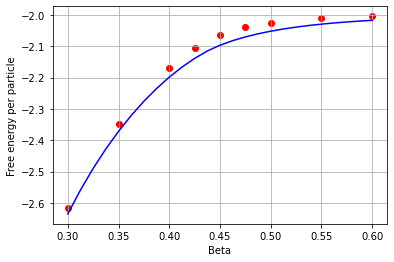

In [8]:
plt.plot(beta, F, color='blue')
plt.scatter(betas, free_energy, color='red')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.show()

Let's estimate the errors in our free energy estimates:

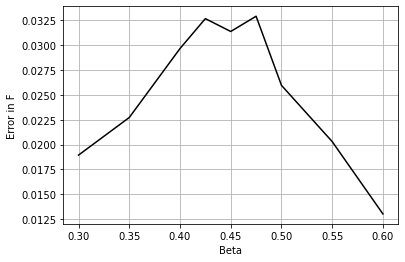

In [9]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error = (free_energy_arr-F)

plt.plot(betas, error, color='black')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

In [25]:
betas1 = betas
error1 = error

## Improved PixelCNN model

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import library #User defined module to define the models

As suggested in [this paper](https://arxiv.org/pdf/1606.05328), there's the naive PixelCNN architecture has limited learning capability (compared to PixelRNN) and has an information blindspot when it's multiple layers deep. Hence, we perform seperate horizontal and vertical convolutions in the new model we call AdvPixelCNN:

In [2]:
model = library.AdvPixelCNN(L=24, kernel_size=2,
                net_width=[16,8], gated=False)#See library.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model
trainer = train.Trainer(model, batch_size=50)

In [3]:
trainer.model.net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nat_conv_block (NatConvBlock (None, 24, 24, 8, 2)      224       
_________________________________________________________________
nat_conv_block_1 (NatConvBlo (None, 24, 24, 4)         324       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 1)         5         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [16]:
beta=0.3
history = trainer.train_loop(iter=2000, 
            beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

100%|██████████| 20/20 [04:16<00:00, 12.84s/it]


In [19]:
history['Energy mean'][-10:]

[<tf.Tensor: shape=(), dtype=float32, numpy=-1097.96>]

In [8]:
trainer.model.load_weights('AdvPCNN_D2(3)/b_0.6')

In [9]:
model = trainer.model

In [10]:
x = model.sample(20)
x_hat = tf.squeeze(model(x))
print(x_hat[:,0,0])

tf.Tensor(
[0.50002396 0.50002396 0.50002396 0.50002396 0.50002396 0.50002396
 0.50002396 0.50002396 0.50002396 0.50002396 0.50002396 0.50002396
 0.50002396 0.50002396 0.50002396 0.50002396 0.50002396 0.50002396
 0.50002396 0.50002396], shape=(20,), dtype=float32)


Compare free energy of trained model with the exact solution:

In [4]:
from scipy import integrate
import math

In [5]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

In [ ]:
#Uncomment below lines and run in case of using Colab
#!apt install subversion
#!svn export 'https://github.com/dinesh110598/ising-autoregressive/trunk/AdvPCNN_Weights'

In [6]:
model = trainer.model
betas = [0.3,0.35,0.4,0.425,0.45,
        0.475,0.5,0.55,0.6]
sample = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('AdvPCNN_D2(3)/b_'+str(beta))
    sample.append(model.sample(100))
    log_prob.append(model.log_prob(sample[-1]))
    energy.append(ising.energy(sample[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [7]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

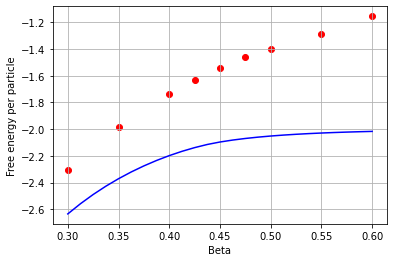

In [8]:
plt.plot(beta, F, color='blue')
plt.scatter(betas, free_energy, color='red')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.show()

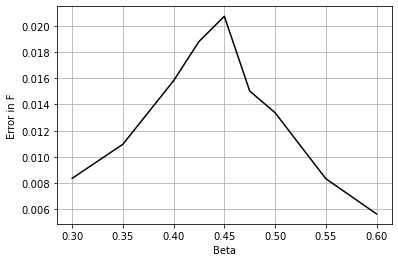

In [15]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error2 = (free_energy_arr-F)

plt.plot(betas, error2, color='black')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

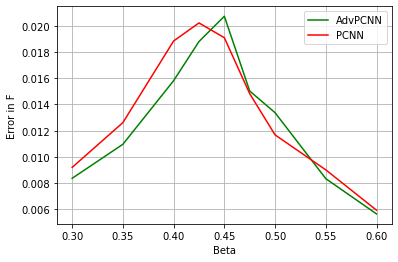

In [26]:
plt.plot(betas, error2, color='green')
plt.plot(betas1, error1, color='red')
plt.legend(['AdvPCNN', 'PCNN'])
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

## Variational PixelCNN model with temperature dependence

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import library #User defined module to define the models

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


The models we considered so far all had to be trained with the temperature fixed, so N models needed to be trained for N temperatures. As training becomes very slow with larger model depth/widths, it's not a feasible idea to train separately for all the temperatures considered. Also, if we're looking to build a neural network that knows the statistical physics of any given system, it rather be for a range of temperatures than just one. Let's initialize this model

In [3]:
model = library.VarPixelCNN(L=36, kernel_size=3, net_width=[16,8,4])#See library.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model
ising.lattice = 'square'
trainer = train.Trainer(model, batch_size=100, learning_rate=0.001)

We're using a different kind of a training loop here which randomly generates its own temperatures:

In [4]:
history = trainer.var_train_loop(2000, anneal=False, mean=0.45, delta=0.15)
#Set anneal=False if you are running this cell second 
#time to train this model further

  0%|          | 0/2000 [00:00<?, ?it/s]WARNING:tensorflow:AutoGraph could not transform <bound method VarPixelCNN.graph_sampler of <library.VarPixelCNN object at 0x7f558b5af940>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute

In [5]:
model.save_weights('VarPCNN_weights2/L36_k3_(16,8,4)_2')

The below code blocks sample and evaluate the free energies of trained models

In [6]:
from scipy import integrate
import math
from time import time
from tqdm import tqdm

In [7]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

In [17]:
model = library.VarPixelCNN(L=54, kernel_size=3, net_width=[16,8,4])
model.load_weights('VarPCNN_weights2/L36_k3_(16,8,4)')
betas = np.arange(0.3,0.6001, 0.0125, np.float32)
mags = np.empty_like(betas)
free_energy = np.empty_like(betas)
F_var = np.empty_like(betas)
i = 0

for beta in betas:
    beta_t = tf.reshape(beta, [1,1,1,1])
    sample = model.sample(400, beta_t)
    mags[i] = np.mean(np.abs(np.mean(sample, axis=(1,2,3))))
    log_prob = model.log_prob(sample, beta_t)
    energy = ising.energy(sample, pbc=True)
    FE = ((log_prob/beta)+energy)/(model.L**2)
    free_energy[i] = np.mean(FE)
    F_var[i] = np.var(FE)
    i += 1

In [18]:
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
error = free_energy - F

In [19]:
t1 = time()
model = library.VarPixelCNN(L=54, kernel_size=3, net_width=[16,8,4])
model.load_weights('VarPCNN_weights2/L36_k3_(16,8,4)_2')
betas = np.arange(0.3,0.6001, 0.0125, np.float32)
mags2 = np.empty_like(betas)
free_energy2 = np.empty_like(betas)
F_var2 = np.empty_like(betas)
i = 0

for beta in betas:
    beta_t = tf.reshape(beta, [1,1,1,1])
    sample = model.sample(400, beta_t)
    mags2[i] = np.mean(np.abs(np.mean(sample, axis=(1,2,3))))
    log_prob = model.log_prob(sample, beta_t)
    energy = ising.energy(sample, pbc=True)
    FE = ((log_prob/beta)+energy)/(model.L**2)
    free_energy2[i] = np.mean(FE)
    F_var2[i] = np.var(FE)
    i += 1
t2 = time()
print(t2-t1)

1073.0607559680939


In [20]:
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
error2 = free_energy2 - F

In [10]:
t1 = time()
model = library.VarPixelCNN(L=48, kernel_size=3, net_width=[16,8,4])
model.load_weights('VarPCNN_weights2/L36_k3_(16,8,4)_2')
beta = 0.5
sample = model.sample(400, beta)
log_prob = model.log_prob(sample, beta)
energy = ising.energy(sample, pbc=True)
FE = ((log_prob/beta)+energy)/(model.L**2)
t2 = time()
print(t2-t1)

32.15819072723389


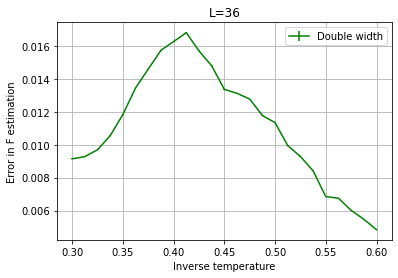

In [22]:
plt.errorbar(betas, error, F_var, ecolor='green', color='green', label='Double width')
plt.title('L=36')
plt.xlabel('Inverse temperature')
plt.ylabel('Error in F estimation')
plt.legend()
plt.grid()

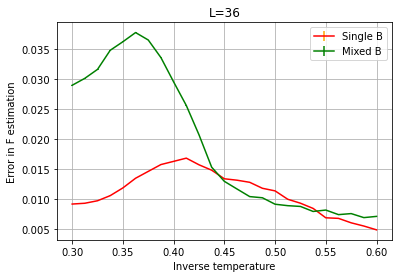

In [21]:
plt.errorbar(betas, error, F_var, color='red', ecolor='orange', label='Single B')
plt.errorbar(betas, error2, F_var2, ecolor='green', color='green', label='Mixed B')
plt.title('L=36')
plt.xlabel('Inverse temperature')
plt.ylabel('Error in F estimation')
plt.legend()
plt.grid()
#plt.savefig('VarPCNN_unif_width_L54.svg', format='svg')

In [17]:
F_var

array([4.6597928e-05, 5.8139674e-05, 4.9546092e-05, 6.5698754e-05,
       6.3818276e-05, 6.7388020e-05, 6.0949122e-05, 7.6748889e-05,
       7.8820623e-05, 8.5924694e-05, 9.0577851e-05, 8.9695372e-05,
       1.0242455e-04, 1.2285476e-04, 1.3701203e-04, 1.2646265e-04,
       1.3992022e-04, 1.0200224e-04, 8.9098365e-05, 8.3244668e-05,
       7.5168035e-05, 6.2608524e-05, 6.0383016e-05, 5.1419585e-05,
       4.5222943e-05], dtype=float32)